# สกัดฝนเรดาร์ด้วยฝนสถานีรายชั่วโมงตามลิสต์ไฟล์ที่ตรงกันแบบเลือกช่วงวัน แล้วเก็บใน gdf


Processing date range: 2018-07-15 to 2018-07-25


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [00:20<00:00, 11.26it/s]


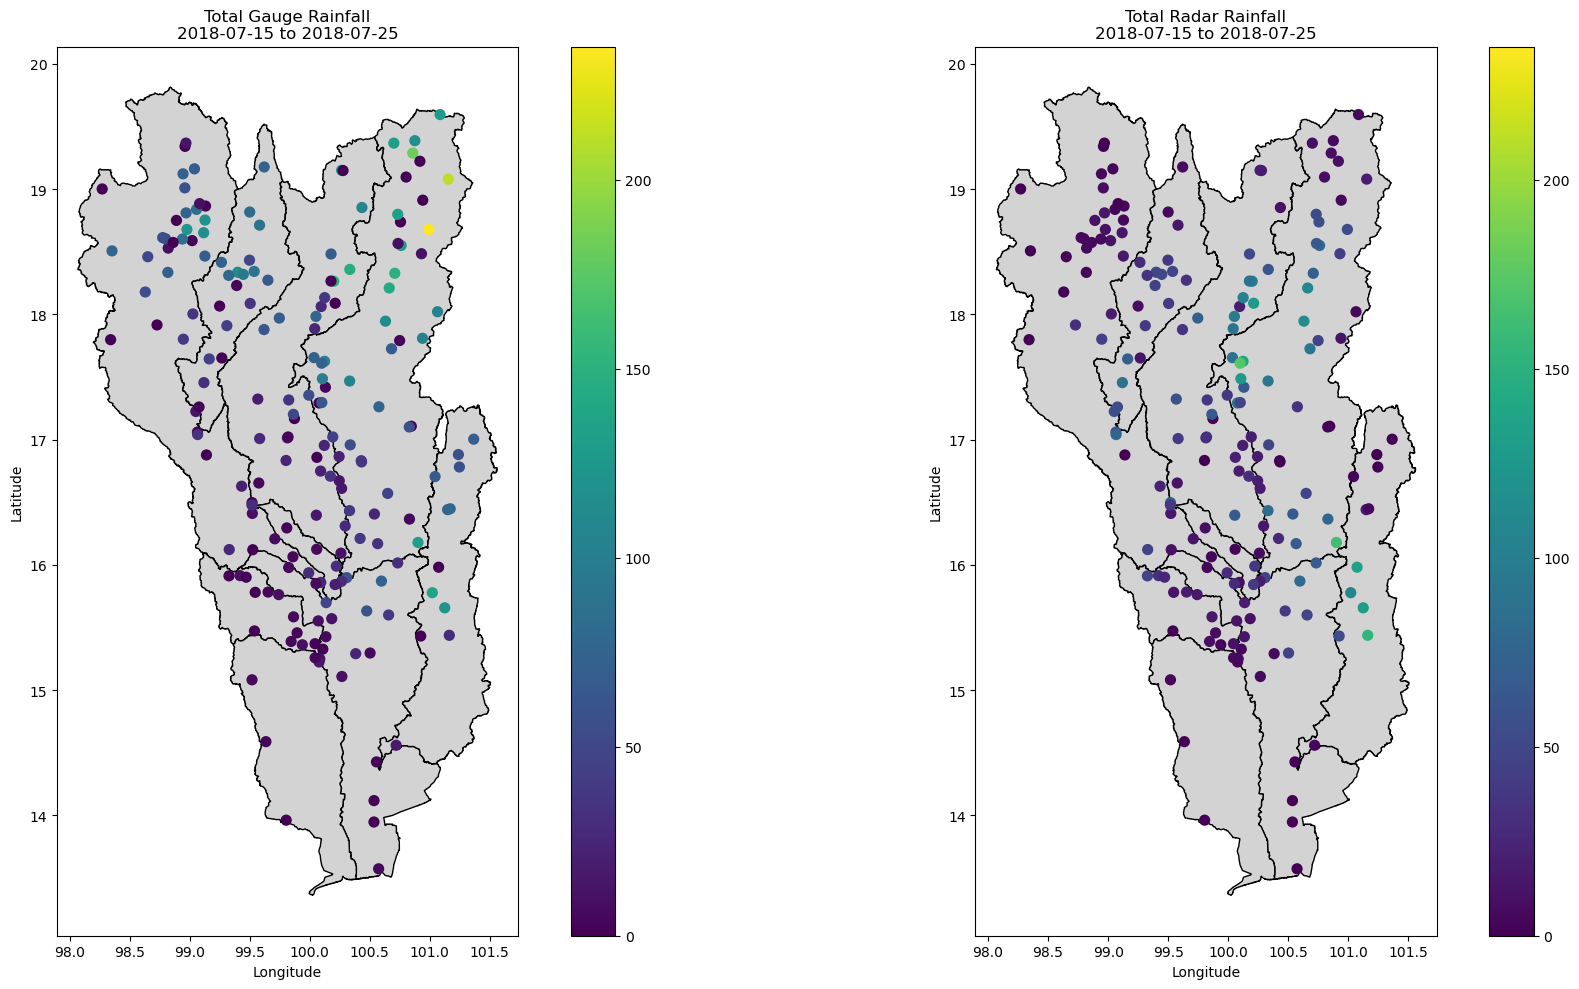

Evaluation Metrics for 2018-07-15 to 2018-07-25:
MSE: 2694.5086
RMSE: 51.9087
R-squared: -0.2670
MAE: 35.7593
NSE: -0.2670
PBIAS: -21.1604
Correlation: 0.2540
MFB: 1.2684
Analysis complete. Results saved in './zProcessing_temp' and './train_test_validate'.


In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import rasterio
from tqdm import tqdm
from datetime import datetime

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def read_radar_data(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

def extract_radar_rainfall(lon, lat, radar_data, transform):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    return radar_data[row, col]

def process_rainfall_data(matched_list, radar_dir, gauge_dir, date_range):
    start_date, end_date = date_range
    all_data = []
    for _, row in tqdm(matched_list.iterrows(), total=len(matched_list)):
        file_date = datetime.strptime(row['Datetime'], '%Y-%m-%d %H:%M:%S').date()
        if start_date <= file_date <= end_date:
            radar_file = os.path.join(radar_dir, row['Radar_File'])
            gauge_file = os.path.join(gauge_dir, row['Gauge_File'])
            
            radar_data, transform = read_radar_data(radar_file)
            gauge_data = pd.read_csv(gauge_file)
            
            gauge_data['radar_rainfall'] = gauge_data.apply(
                lambda x: extract_radar_rainfall(x['longitude'], x['latitude'], radar_data, transform),
                axis=1
            )
            
            gauge_data['datetime'] = row['Datetime']
            all_data.append(gauge_data)
    
    return pd.concat(all_data, ignore_index=True)

def calculate_metrics(observed, predicted):
    mse = mean_squared_error(observed, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(observed, predicted)
    mae = mean_absolute_error(observed, predicted)
    nse = 1 - (np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2))
    pbias = np.sum(predicted - observed) / np.sum(observed) * 100
    correlation = np.corrcoef(observed, predicted)[0, 1]  
    mfb = np.sum(observed) / np.sum(predicted) ## check
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R-squared': r2,
        'MAE': mae,
        'NSE': nse,
        'PBIAS': pbias,
        'Correlation': correlation,
        'MFB': mfb
    }

def plot_rainfall_maps(gdf, basin_shape, date_range):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    vmin = min(gdf['rain'].min(), gdf['radar_rainfall'].min())
    vmax = max(gdf['rain'].max(), gdf['radar_rainfall'].max())
    
    basin_shape.plot(ax=ax1, color='lightgrey', edgecolor='black')
    basin_shape.plot(ax=ax2, color='lightgrey', edgecolor='black')
    
    gdf.plot(ax=ax1, column='rain', cmap='viridis', legend=True, vmin=vmin, vmax=vmax, markersize=50)
    gdf.plot(ax=ax2, column='radar_rainfall', cmap='viridis', legend=True, vmin=vmin, vmax=vmax, markersize=50)
    
    ax1.set_title(f'Total Gauge Rainfall\n{date_range[0]} to {date_range[1]}')
    ax2.set_title(f'Total Radar Rainfall\n{date_range[0]} to {date_range[1]}')
    
    for ax in (ax1, ax2):
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()

def plot_scatter(gdf, date_range):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='rain', y='radar_rainfall', data=gdf)
    plt.plot([0, gdf['rain'].max()], [0, gdf['rain'].max()], 'r--')
    plt.xlabel('Gauge Rainfall')
    plt.ylabel('Radar Rainfall')
    plt.title(f'Gauge vs Radar Rainfall\n{date_range[0]} to {date_range[1]}')
    plt.show()

def main():
    radar_dir = '../00run_batch_acchr_codes/2output/0Hourly/0Sontihn_RF/0CBB_Pulse/0output_mosaic/'
    gauge_dir = '../1data/3Gauges/rain_hourly/0Sontihn/2Final_hourly_dates/'
    matched_list_file = './zProcessing_temp/matched_rainfall_files.csv'
    train_test_dir = './train_test_validate'
    ensure_dir(train_test_dir)

    # Read matched list
    matched_list = pd.read_csv(matched_list_file)

    # Load Chao Phraya Basin shapefile
    basin_shape = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

    # Set date ranges เลือกช่วงวันได้
    date_ranges = [
        (datetime(2018, 7, 15).date(), datetime(2018, 7, 25).date())#,
        #(datetime(2018, 8, 5).date(), datetime(2018, 8, 9).date())
    ]

    for date_range in date_ranges:
        print(f"\nProcessing date range: {date_range[0]} to {date_range[1]}")
        
        # Process rainfall data
        data = process_rainfall_data(matched_list, radar_dir, gauge_dir, date_range)

        # Sum rainfall by station
        station_data = data.groupby('station_code').agg({
            'longitude': 'first',
            'latitude': 'first',
            'rain': 'sum',
            'radar_rainfall': 'sum'
        }).reset_index()

        # Convert to GeoDataFrame
        gdf = gpd.GeoDataFrame(
            station_data, 
            geometry=gpd.points_from_xy(station_data.longitude, station_data.latitude),
            crs=basin_shape.crs
        )

        # Perform K-Fold split
        '''
        kf = KFold(n_splits=20, shuffle=True, random_state=42)
        for i, (train_index, test_index) in enumerate(kf.split(gdf)):
            train_data = gdf.iloc[train_index]
            test_data = gdf.iloc[test_index]
            
            train_data.to_file(f"{train_test_dir}/train_fold_{i}_{date_range[0]}_{date_range[1]}.gpkg", driver="GPKG")
            test_data.to_file(f"{train_test_dir}/test_fold_{i}_{date_range[0]}_{date_range[1]}.gpkg", driver="GPKG")
        '''

        # Plot maps
        plot_rainfall_maps(gdf, basin_shape, date_range)

        # Calculate and print metrics
        metrics = calculate_metrics(gdf['rain'], gdf['radar_rainfall'])
        print(f"Evaluation Metrics for {date_range[0]} to {date_range[1]}:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")

        # Create scatter plot
        #plot_scatter(gdf, date_range)

        # Save results
        gdf.to_csv(f'./zProcessing_temp/total_rainfall_by_station_{date_range[0]}_{date_range[1]}.csv', index=False)

    print("Analysis complete. Results saved in './zProcessing_temp' and './train_test_validate'.")

if __name__ == "__main__":
    main()

## พลอตฝนสถานีรายเหตุการณ์

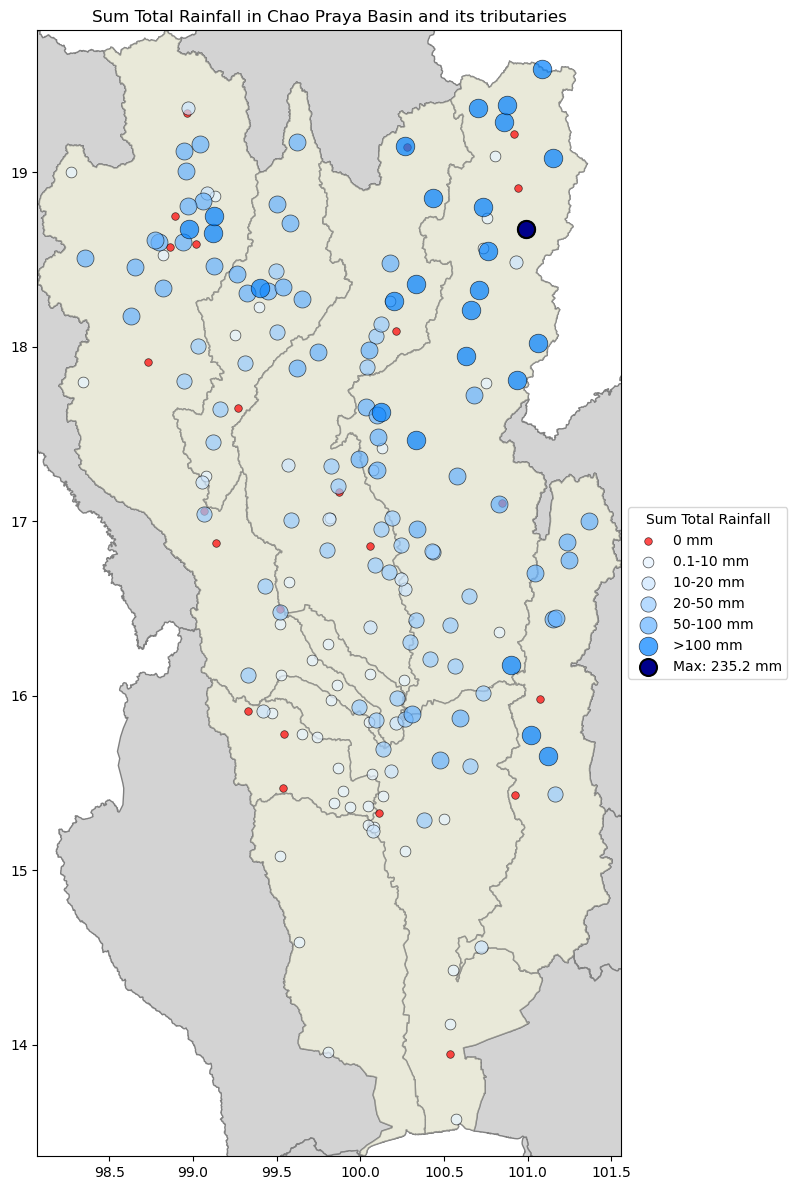

Total number of stations: 192
Stations with sum total rainfall 0 mm: 23
Stations with sum total rainfall 0.1-10 mm: 46
Stations with sum total rainfall 10-20 mm: 14
Stations with sum total rainfall 20-50 mm: 40
Stations with sum total rainfall 50-100 mm: 43
Stations with sum total rainfall >100 mm: 26
Station with max sum total rainfall: MCRM (235.2 mm)


In [2]:
# Read the shapefiles and sum total rainfall CSV file
basin_map = gpd.read_file('../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_UTM47N.shp', encoding="UTF-8")
all_basin = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Read the GeoDataFrame from the saved CSV file
csv_file = f'./zProcessing_temp/total_rainfall_by_station_2018-07-15_2018-07-25.csv'  # Adjust the date range as needed
sum_rain_df = pd.read_csv(csv_file)

# Convert the dataframe to a GeoDataFrame
geo_df = gpd.GeoDataFrame(sum_rain_df, geometry=gpd.points_from_xy(sum_rain_df.longitude, sum_rain_df.latitude))
geo_df.set_crs(epsg=4326, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the basins
basin_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=1)
all_basin.to_crs(epsg=4326).plot(ax=ax, color='lightyellow', edgecolor='grey', linewidth=1, alpha=0.5)

# Define rain intensity classes
rain_classes = [0, 0.1, 10, 20, 50, 100, np.inf]
colors = ['red', '#E6F3FF', '#CCE6FF', '#99CCFF', '#66B2FF', '#0080FF']
labels = ['0', '0.1-10', '10-20', '20-50', '50-100', '>100']

# Plot all stations
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    mask = (geo_df['rain'] >= lower) & (geo_df['rain'] < upper)
    ax.scatter(geo_df.loc[mask, 'longitude'], geo_df.loc[mask, 'latitude'], 
               c=colors[i], s=(i+1)*30, alpha=0.7, edgecolor='black', linewidth=0.5,
               label=f'{labels[i]} mm')

# Highlight the station with the highest sum  total rainfall
max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
           c='darkblue', s=150, alpha=1, edgecolor='black', linewidth=1.5,
           label=f'Max: {max_rain_station["rain"]:.1f} mm')

# Set the extent to focus on Chao Praya basin
ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])

# Add legend
ax.legend(title='Sum Total Rainfall', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Sum Total Rainfall in Chao Praya Basin and its tributaries')
plt.tight_layout()
plt.savefig('../3output/0map/sum_total_rainfall_map.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Total number of stations: {len(geo_df)}")
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    count = ((geo_df['rain'] >= lower) & (geo_df['rain'] < upper)).sum()
    print(f"Stations with sum total rainfall {labels[i]} mm: {count}")
print(f"Station with max sum total rainfall: {max_rain_station['station_code']} ({max_rain_station['rain']:.1f} mm)")

## พลอตฝนเรดาร์ตำแหน่งฝนสถานีรายเหตุการณ์

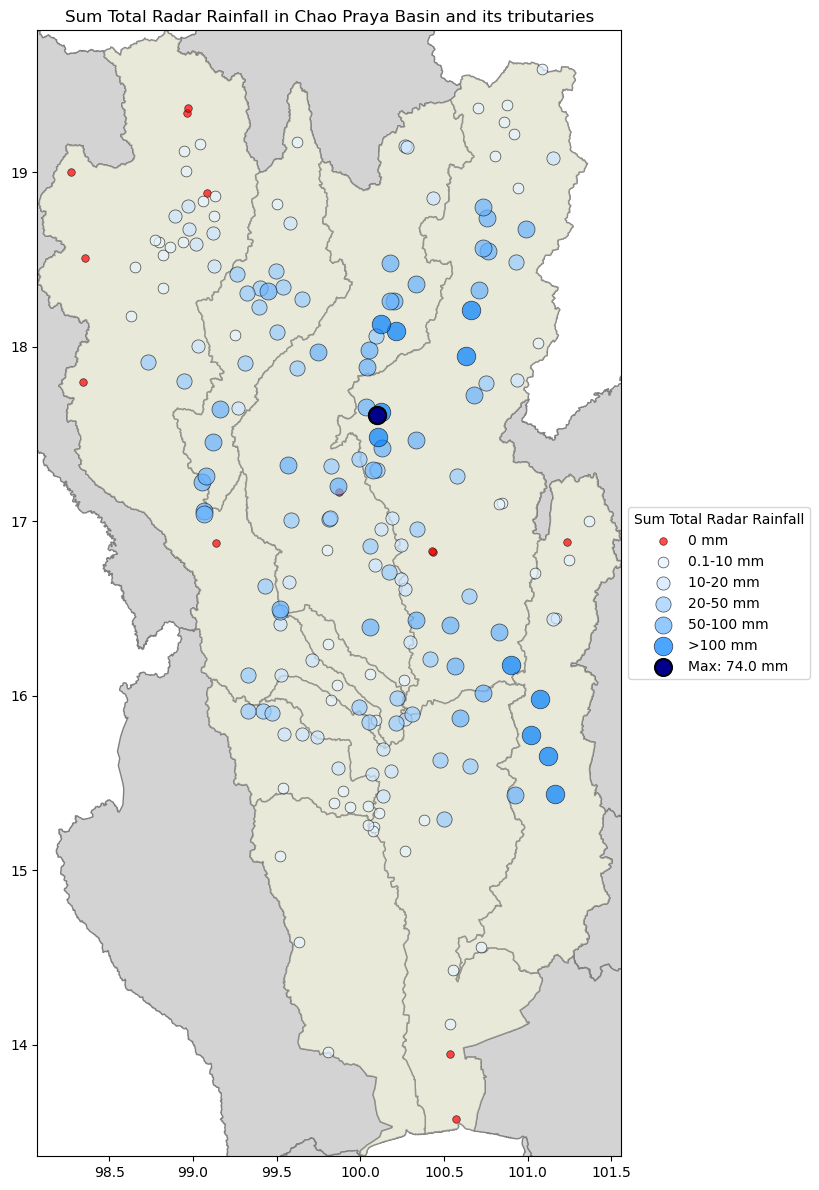

Total number of stations: 192
Stations with sum total rainfall 0 mm: 13
Stations with sum total rainfall 0.1-10 mm: 55
Stations with sum total rainfall 10-20 mm: 35
Stations with sum total rainfall 20-50 mm: 41
Stations with sum total rainfall 50-100 mm: 36
Stations with sum total rainfall >100 mm: 12
Station with max sum total rainfall: NAN011 (173.1 mm)


In [3]:
# Read the shapefiles and sum total rainfall CSV file
basin_map = gpd.read_file('../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_UTM47N.shp', encoding="UTF-8")
all_basin = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Read the GeoDataFrame from the saved CSV file
csv_file = './zProcessing_temp/total_rainfall_by_station_2018-07-15_2018-07-25.csv'  # Adjust the date range as needed
sum_rain_df = pd.read_csv(csv_file)

# Convert the dataframe to a GeoDataFrame
geo_df = gpd.GeoDataFrame(sum_rain_df, geometry=gpd.points_from_xy(sum_rain_df.longitude, sum_rain_df.latitude))
geo_df.set_crs(epsg=4326, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the basins
basin_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=1)
all_basin.to_crs(epsg=4326).plot(ax=ax, color='lightyellow', edgecolor='grey', linewidth=1, alpha=0.5)

# Define rain intensity classes
rain_classes = [0, 0.1, 10, 20, 50, 100, np.inf]
colors = ['red', '#E6F3FF', '#CCE6FF', '#99CCFF', '#66B2FF', '#0080FF']
labels = ['0', '0.1-10', '10-20', '20-50', '50-100', '>100']

# Plot all stations
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    mask = (geo_df['radar_rainfall'] >= lower) & (geo_df['radar_rainfall'] < upper)
    ax.scatter(geo_df.loc[mask, 'longitude'], geo_df.loc[mask, 'latitude'], 
               c=colors[i], s=(i+1)*30, alpha=0.7, edgecolor='black', linewidth=0.5,
               label=f'{labels[i]} mm')

# Highlight the station with the highest sum  total rainfall
max_rain_station = geo_df.loc[geo_df['radar_rainfall'].idxmax()]
ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
           c='darkblue', s=150, alpha=1, edgecolor='black', linewidth=1.5,
           label=f'Max: {max_rain_station["rain"]:.1f} mm')

# Set the extent to focus on Chao Praya basin
ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])

# Add legend
ax.legend(title='Sum Total Radar Rainfall', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Sum Total Radar Rainfall in Chao Praya Basin and its tributaries')
plt.tight_layout()
plt.savefig('../3output/0map/sum_total_radar_rainfall_map.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"Total number of stations: {len(geo_df)}")
for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
    count = ((geo_df['radar_rainfall'] >= lower) & (geo_df['radar_rainfall'] < upper)).sum()
    print(f"Stations with sum total rainfall {labels[i]} mm: {count}")
print(f"Station with max sum total rainfall: {max_rain_station['station_code']} ({max_rain_station['radar_rainfall']:.1f} mm)")

# ทำ Kfolds 20 split คำนวณจำนวนตามการถ่วงน้ำหนักด้วยพื้นที่ลุ่มน้ำ

Columns in all_basin: Index(['MB_CODE', 'MBASIN_T', 'MBASIN_E', 'AREA_SQKM', 'geometry'], dtype='object')
Columns in geo_df: Index(['station_code', 'longitude', 'latitude', 'rain', 'radar_rainfall',
       'geometry'],
      dtype='object')
Number of splits: 20
Total samples: 169
Split 1:
  Train samples: 122
  Test samples: 47
Split 2:
  Train samples: 122
  Test samples: 47
Split 3:
  Train samples: 122
  Test samples: 47
Split 4:
  Train samples: 122
  Test samples: 47
Split 5:
  Train samples: 122
  Test samples: 47
Split 6:
  Train samples: 122
  Test samples: 47
Split 7:
  Train samples: 122
  Test samples: 47
Split 8:
  Train samples: 122
  Test samples: 47
Split 9:
  Train samples: 122
  Test samples: 47
Split 10:
  Train samples: 122
  Test samples: 47
Split 11:
  Train samples: 122
  Test samples: 47
Split 12:
  Train samples: 122
  Test samples: 47
Split 13:
  Train samples: 122
  Test samples: 47
Split 14:
  Train samples: 122
  Test samples: 47
Split 15:
  Train samples: 1

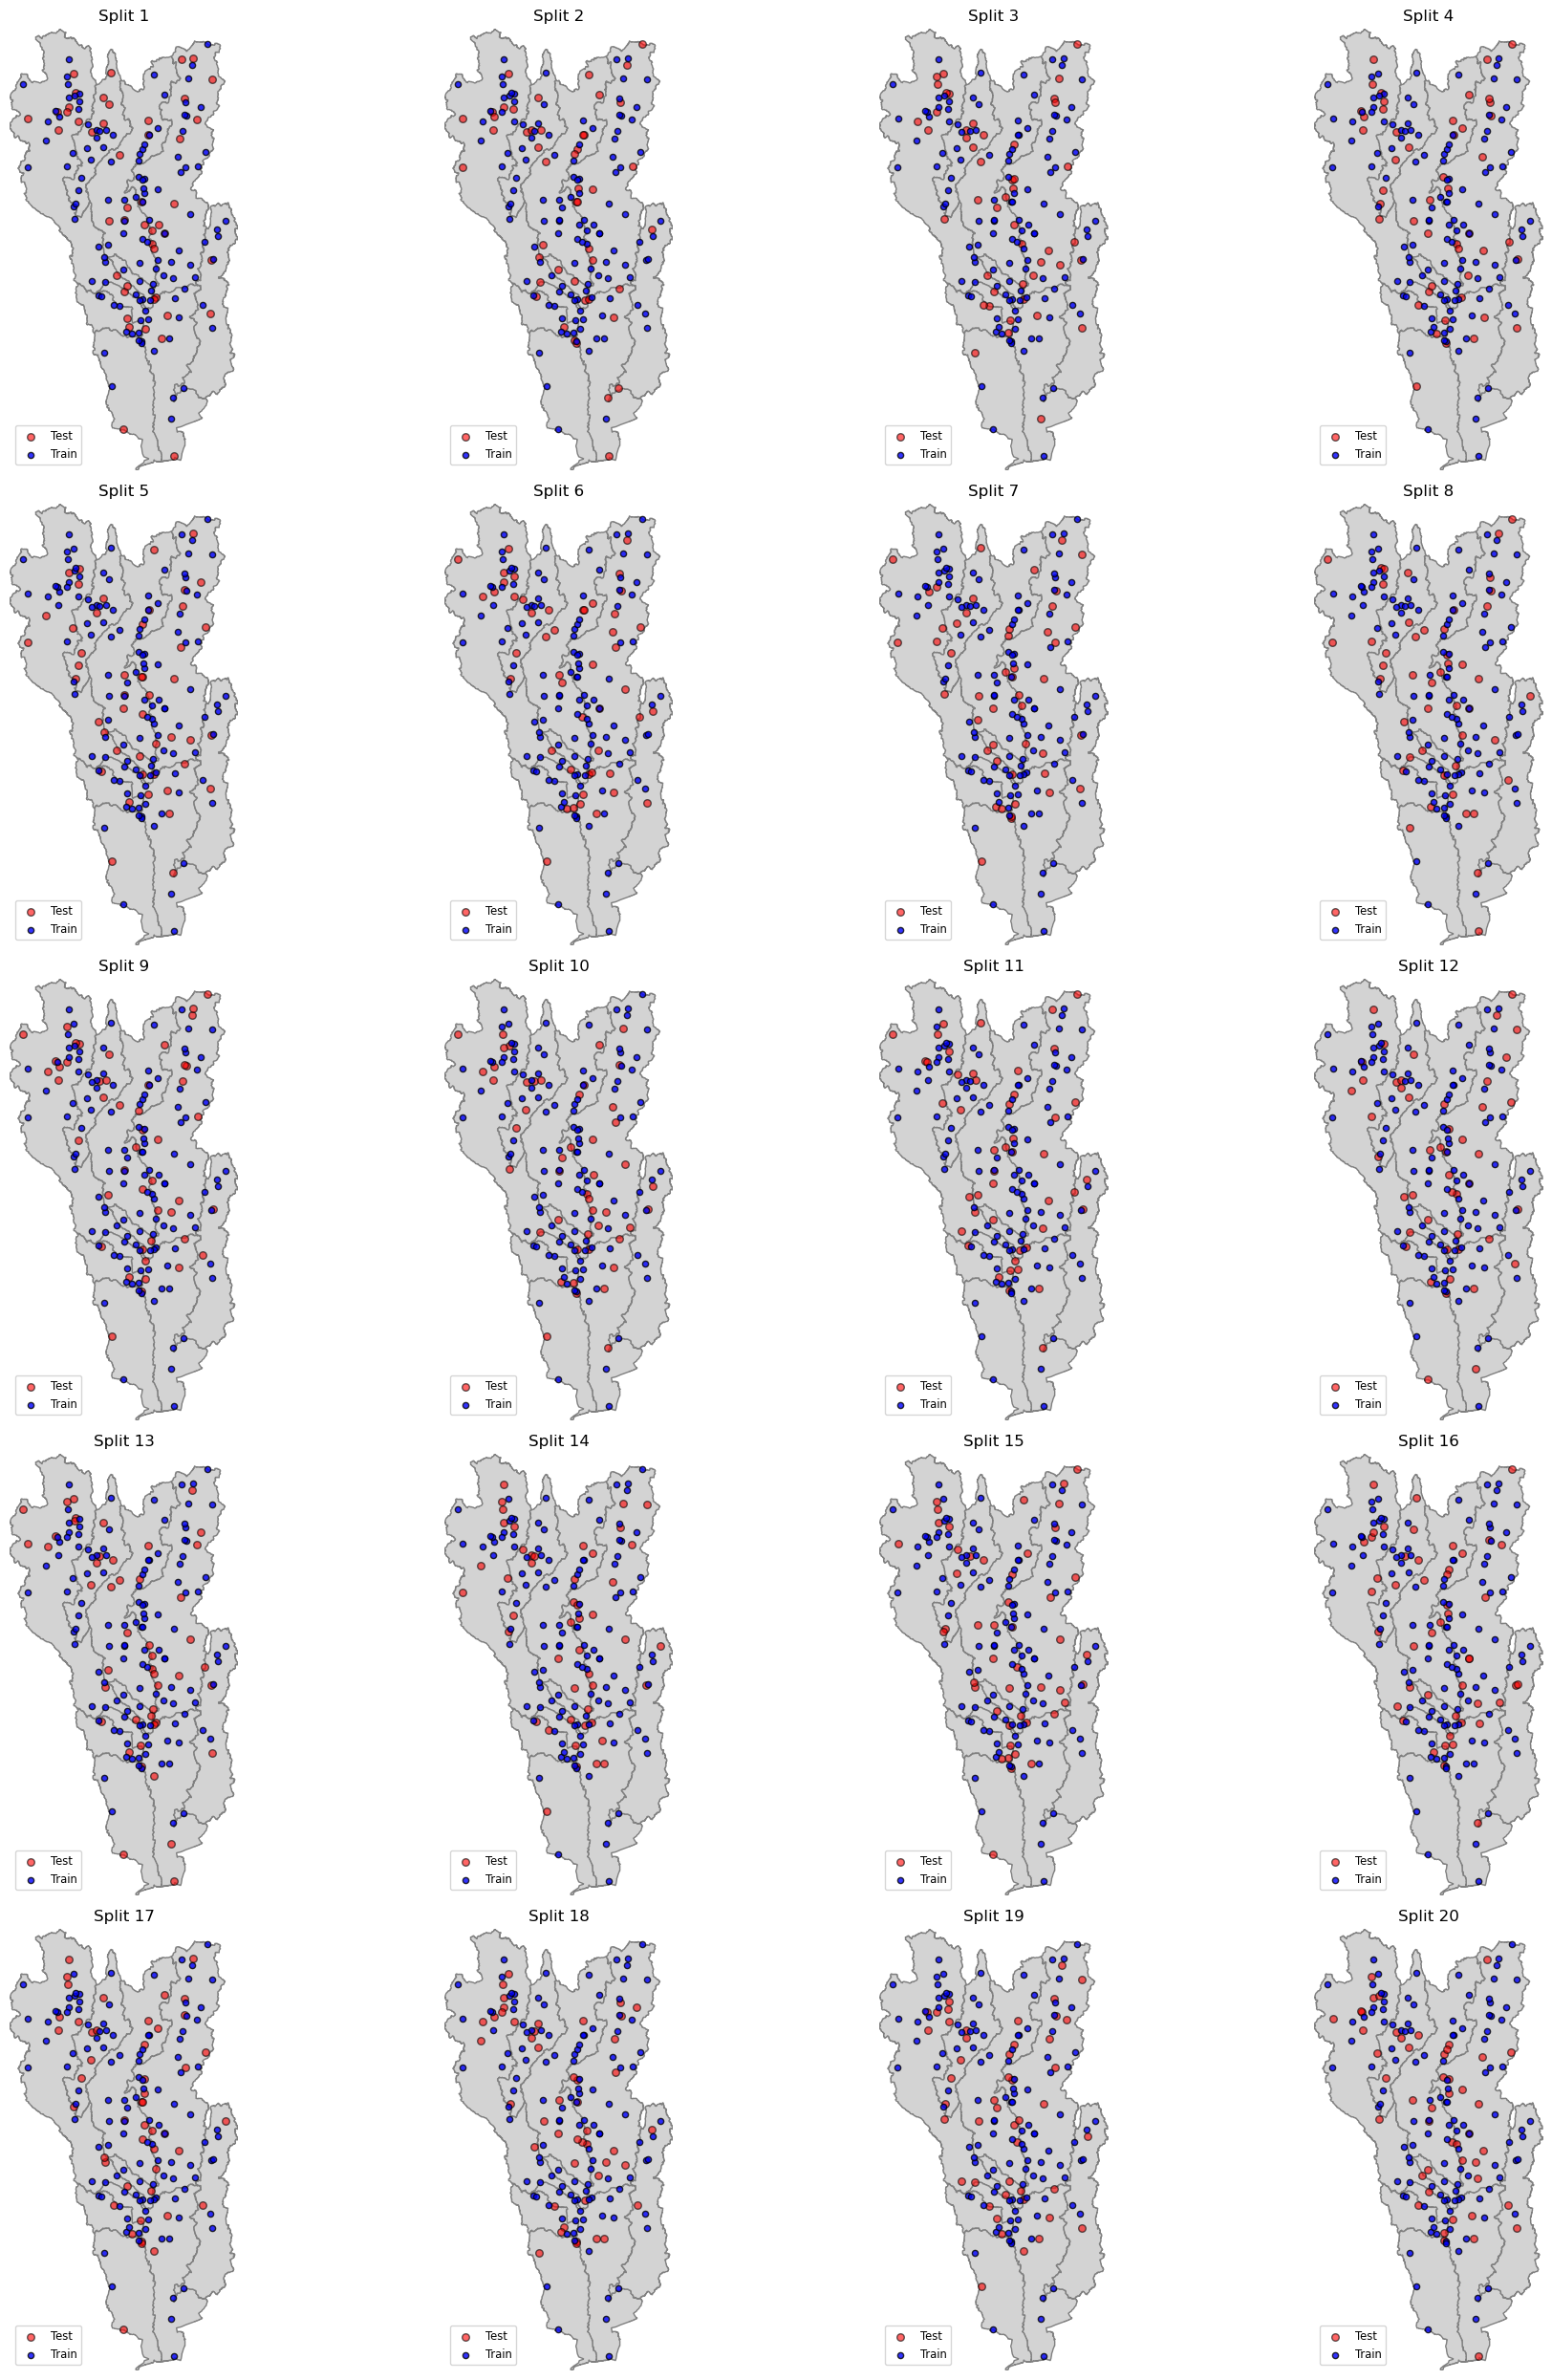


Distribution of train and test samples for each sub-basin in each fold:

Fold 1:
         Train  Test
MB_CODE             
06          26    10
07          12     5
08          20     8
09          35    14
10          13     5
11           6     2
12           7     2
13           3     1
Total Train: 122, Total Test: 47

Fold 2:
         Train  Test
MB_CODE             
06          26    10
07          12     5
08          20     8
09          35    14
10          13     5
11           6     2
12           7     2
13           3     1
Total Train: 122, Total Test: 47

Fold 3:
         Train  Test
MB_CODE             
06          26    10
07          12     5
08          20     8
09          35    14
10          13     5
11           6     2
12           7     2
13           3     1
Total Train: 122, Total Test: 47

Fold 4:
         Train  Test
MB_CODE             
06          26    10
07          12     5
08          20     8
09          35    14
10          13     5
11           6 

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold

def weighted_spatial_stratified_split(gdf, all_basin, n_splits=20, test_size=0.3, random_state=None, verbose=True):
    np.random.seed(random_state)
    
    # Perform spatial join to assign basin codes to stations
    gdf = gpd.sjoin(gdf, all_basin[['MB_CODE', 'AREA_SQKM', 'geometry']], how='left', predicate='within')
    
    # Calculate basin weights
    basin_weights = gdf.groupby('MB_CODE')['AREA_SQKM'].first() / gdf['AREA_SQKM'].sum()
    
    # Assign weights to each point
    gdf['weight'] = gdf['MB_CODE'].map(basin_weights)
    
    nan_weights = gdf['weight'].isna()
    if nan_weights.any():
        print(f"Warning: {nan_weights.sum()} points have NaN weights.")
        print("These points will be assigned equal weights.")
        print("Stations with NaN weights:", gdf.loc[nan_weights, 'station_code'].tolist())
        gdf.loc[nan_weights, 'weight'] = 1 / len(gdf)
    
    gdf['weight'] = gdf['weight'] / gdf['weight'].sum()
    
    unique_basins = gdf['MB_CODE'].unique()
    basin_to_indices = defaultdict(list)
    for idx, basin in enumerate(gdf['MB_CODE']):
        basin_to_indices[basin].append(idx)
    
    splits = []
    for _ in range(n_splits):
        test_indices = []
        for basin in unique_basins:
            basin_indices = basin_to_indices[basin]
            n_test = max(1, int(len(basin_indices) * test_size))
            basin_weights = gdf.loc[basin_indices, 'weight'].values
            basin_weights /= basin_weights.sum()
            test_indices.extend(np.random.choice(basin_indices, size=n_test, replace=False, p=basin_weights))
        
        train_indices = np.setdiff1d(np.arange(len(gdf)), test_indices)
        splits.append((train_indices, test_indices))
    
    if verbose:
        print(f"Number of splits: {n_splits}")
        print(f"Total samples: {len(gdf)}")
        for i, (train_index, test_index) in enumerate(splits):
            print(f"Split {i+1}:")
            print(f"  Train samples: {len(train_index)}")
            print(f"  Test samples: {len(test_index)}")
        
        print("\nWeight statistics:")
        print(gdf['weight'].describe())
        print("\nUnique basins in gdf:", gdf['MB_CODE'].unique())
        print("\nUnique codes in all_basin:", all_basin['MB_CODE'].unique())
    
    return splits, gdf

# Load the basin maps
basin_map = gpd.read_file('../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_UTM47N.shp', encoding="UTF-8")
all_basin = gpd.read_file('../1data/1GIS/0base_map_gis/Chaophraya_Basins_others_ONWR_Law_WGS84Geo.shp')

# Read the GeoDataFrame from the saved CSV file
csv_file = './zProcessing_temp/total_rainfall_by_station_2018-07-15_2018-07-25.csv'  # Adjust the date range as needed
geo_df = pd.read_csv(csv_file)

# Convert to GeoDataFrame
geo_df = gpd.GeoDataFrame(
    geo_df, 
    geometry=gpd.points_from_xy(geo_df.longitude, geo_df.latitude),
    crs=all_basin.crs
)

# Print column names to verify
print("Columns in all_basin:", all_basin.columns)
print("Columns in geo_df:", geo_df.columns)

# 1. Delete records with rain equal to 0
geo_df = geo_df[geo_df['rain'] > 0].reset_index(drop=True)

# 2. Perform weighted spatial stratified split with cross-validation
splits, geo_df = weighted_spatial_stratified_split(geo_df, all_basin, n_splits=20, test_size=0.3, random_state=42, verbose=True)
print("Weighted spatial stratified split with cross-validation successful.")

# 3. Visualize all splits
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.flatten()

for i, (train_index, test_index) in enumerate(splits):
    ax = axes[i]
    all_basin.plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=1)
    
    train_stations = geo_df.iloc[train_index]
    test_stations = geo_df.iloc[test_index]
    
    ax.scatter(test_stations.longitude, test_stations.latitude, c='red', label='Test', alpha=0.6, s=30, edgecolor='black')
    ax.scatter(train_stations.longitude, train_stations.latitude, c='blue', label='Train', alpha=0.8, s=20, edgecolor='black')
    
    ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
    ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])
    ax.legend(loc='lower left', fontsize='small')
    ax.set_title(f'Split {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('../3output/0map/chao_phraya_cross_validation_splits.jpg', dpi=300, bbox_inches='tight')
plt.show()

# 4. Report the distribution for each fold
print("\nDistribution of train and test samples for each sub-basin in each fold:")
for i, (train_index, test_index) in enumerate(splits):
    train_df = geo_df.iloc[train_index]
    test_df = geo_df.iloc[test_index]
    distribution = pd.DataFrame({
        'Train': train_df.groupby('MB_CODE').size(),
        'Test': test_df.groupby('MB_CODE').size()
    }).fillna(0)
    
    print(f"\nFold {i+1}:")
    print(distribution)
    print(f"Total Train: {len(train_index)}, Total Test: {len(test_index)}")

# 5. Calculate and report the average distribution across splits
distribution_across_splits = []
for i, (train_index, test_index) in enumerate(splits):
    train_df = geo_df.iloc[train_index]
    test_df = geo_df.iloc[test_index]
    distribution = pd.DataFrame({
        'Train': train_df.groupby('MB_CODE').size(),
        'Test': test_df.groupby('MB_CODE').size()
    }).fillna(0)
    distribution_across_splits.append(distribution)

average_distribution = pd.concat(distribution_across_splits).groupby(level=0).mean()
print("\nAverage distribution across splits:")
print(average_distribution)
print("\nAverage percentage distribution across splits:")
print(average_distribution.div(average_distribution.sum(axis=1), axis=0) * 100)

# 6. Identify basins with consistently small samples
small_sample_basins = average_distribution[average_distribution.sum(axis=1) < 20].index
if len(small_sample_basins) > 0:
    print("\nBasins with consistently small samples (< 20 on average):")
    print(small_sample_basins.tolist())
    print("Consider removing or combining these basins for more robust analysis.")

# 7. Save the cross-validation splits
for i, (train_index, test_index) in enumerate(splits):
    train_df = geo_df.iloc[train_index]
    test_df = geo_df.iloc[test_index]
    train_df.to_csv(f'./train_test_validate/train_split_{i+1}.csv', index=False)
    test_df.to_csv(f'./train_test_validate/test_split_{i+1}.csv', index=False)

print("Cross-validation splits saved to output files.")